In [26]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('new_train_sample.csv')

In [3]:
df.shape

(4758418, 46)

In [4]:
df.isnull().sum()

Unnamed: 0                  0
Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2733136
IncidentGrade           25775
ActionGrouped         4730205
ActionGranular        4730205
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4710241
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4721038
FileName  

In [5]:
df = df.dropna(thresh=0.4 * len(df), axis=1)

In [10]:
df["IncidentGrade"].fillna(df["IncidentGrade"].mode()[0],inplace=True)

C:\Users\deepa\AppData\Local\Temp\ipykernel_21664\872256489.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["IncidentGrade"].fillna(df["IncidentGrade"].mode()[0],inplace=True)


In [15]:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
df.drop("Timestamp",axis=1,inplace=True)

In [16]:
df.shape

(4758418, 38)

In [19]:
missing_datas = df.groupby(df["MitreTechniques"].isnull())['IncidentGrade'].value_counts()
missing_datas

MitreTechniques  IncidentGrade 
False            TruePositive       829722
                 BenignPositive     698365
                 FalsePositive      497195
True             BenignPositive    1382184
                 TruePositive       832365
                 FalsePositive      518587
Name: count, dtype: int64

In [21]:
technique_count = df.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")
sorted_technique = technique_count.sort_values(["IncidentGrade","count"],ascending=[True, False])
most_commons = sorted_technique.loc[sorted_technique.groupby("IncidentGrade")["count"].idxmax()]
technique_count
sorted_technique
most_commons

,IncidentGrade,MitreTechniques,count
941,BenignPositive,T1566.002,196307
1290,FalsePositive,T1078;T1078.004,154018
1767,TruePositive,T1078;T1078.004,505653


In [22]:
fill_mapping = {
    "BenignPositive": "T1566.002",
    "FalsePositive": "T1078;T1078.004",
    "TruePositive": "T1078;T1078.004"
}

df["MitreTechniques"] = df["MitreTechniques"].fillna(df["IncidentGrade"].map(fill_mapping))


In [23]:
df.isnull().sum()

Unnamed: 0            0
Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
MitreTechniques       0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Hour                  0
DayOfWeek             0
dtype: int64

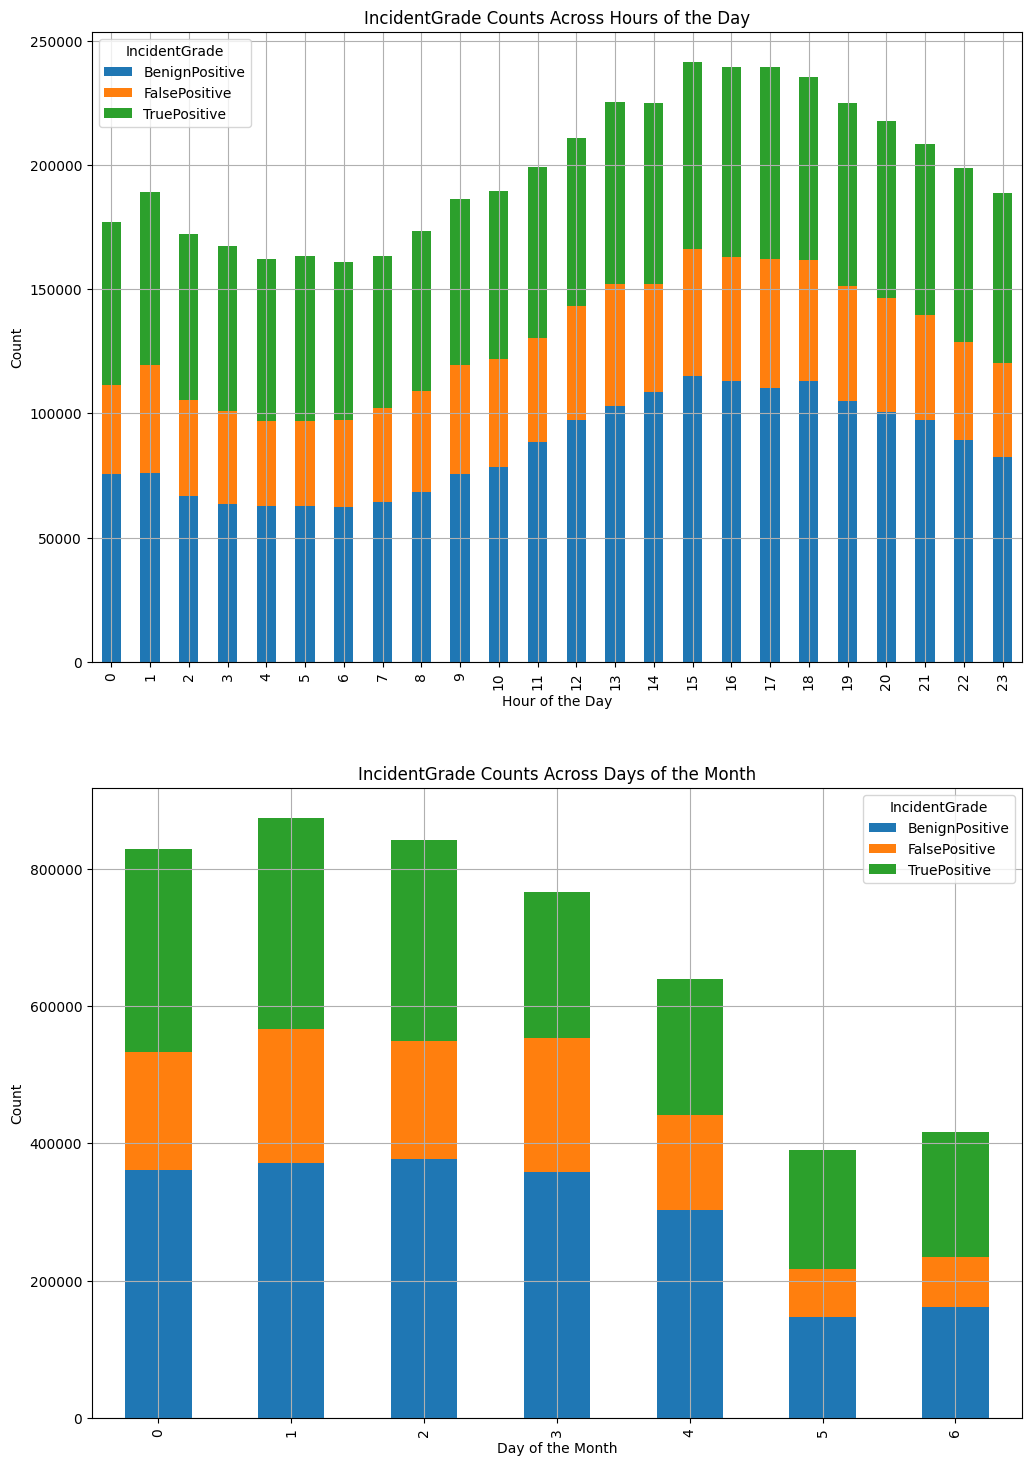

In [27]:
day_incident_grade = df.groupby(['DayOfWeek', 'IncidentGrade']).size().unstack()
hour_incident_grade = df.groupby(['Hour', 'IncidentGrade']).size().unstack()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 18))

# Hourly distribution (stacked bar plot)
hour_incident_grade.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("IncidentGrade Counts Across Hours of the Day")
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Count")
axes[0].legend(title='IncidentGrade')
axes[0].grid(True)

# Daily distribution (stacked bar plot)
day_incident_grade.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("IncidentGrade Counts Across Days of the Month")
axes[1].set_xlabel("Day of the Month")
axes[1].set_ylabel("Count")
axes[1].legend(title='IncidentGrade')
axes[1].grid(True)

In [32]:
df["MitreTechniques"] = df["MitreTechniques"].map(lambda x: x.split(";")[0])

In [34]:
df[df.duplicated()]

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Hour,DayOfWeek


In [35]:
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [50]:
df= df.drop(columns=['Unnamed: 0'])

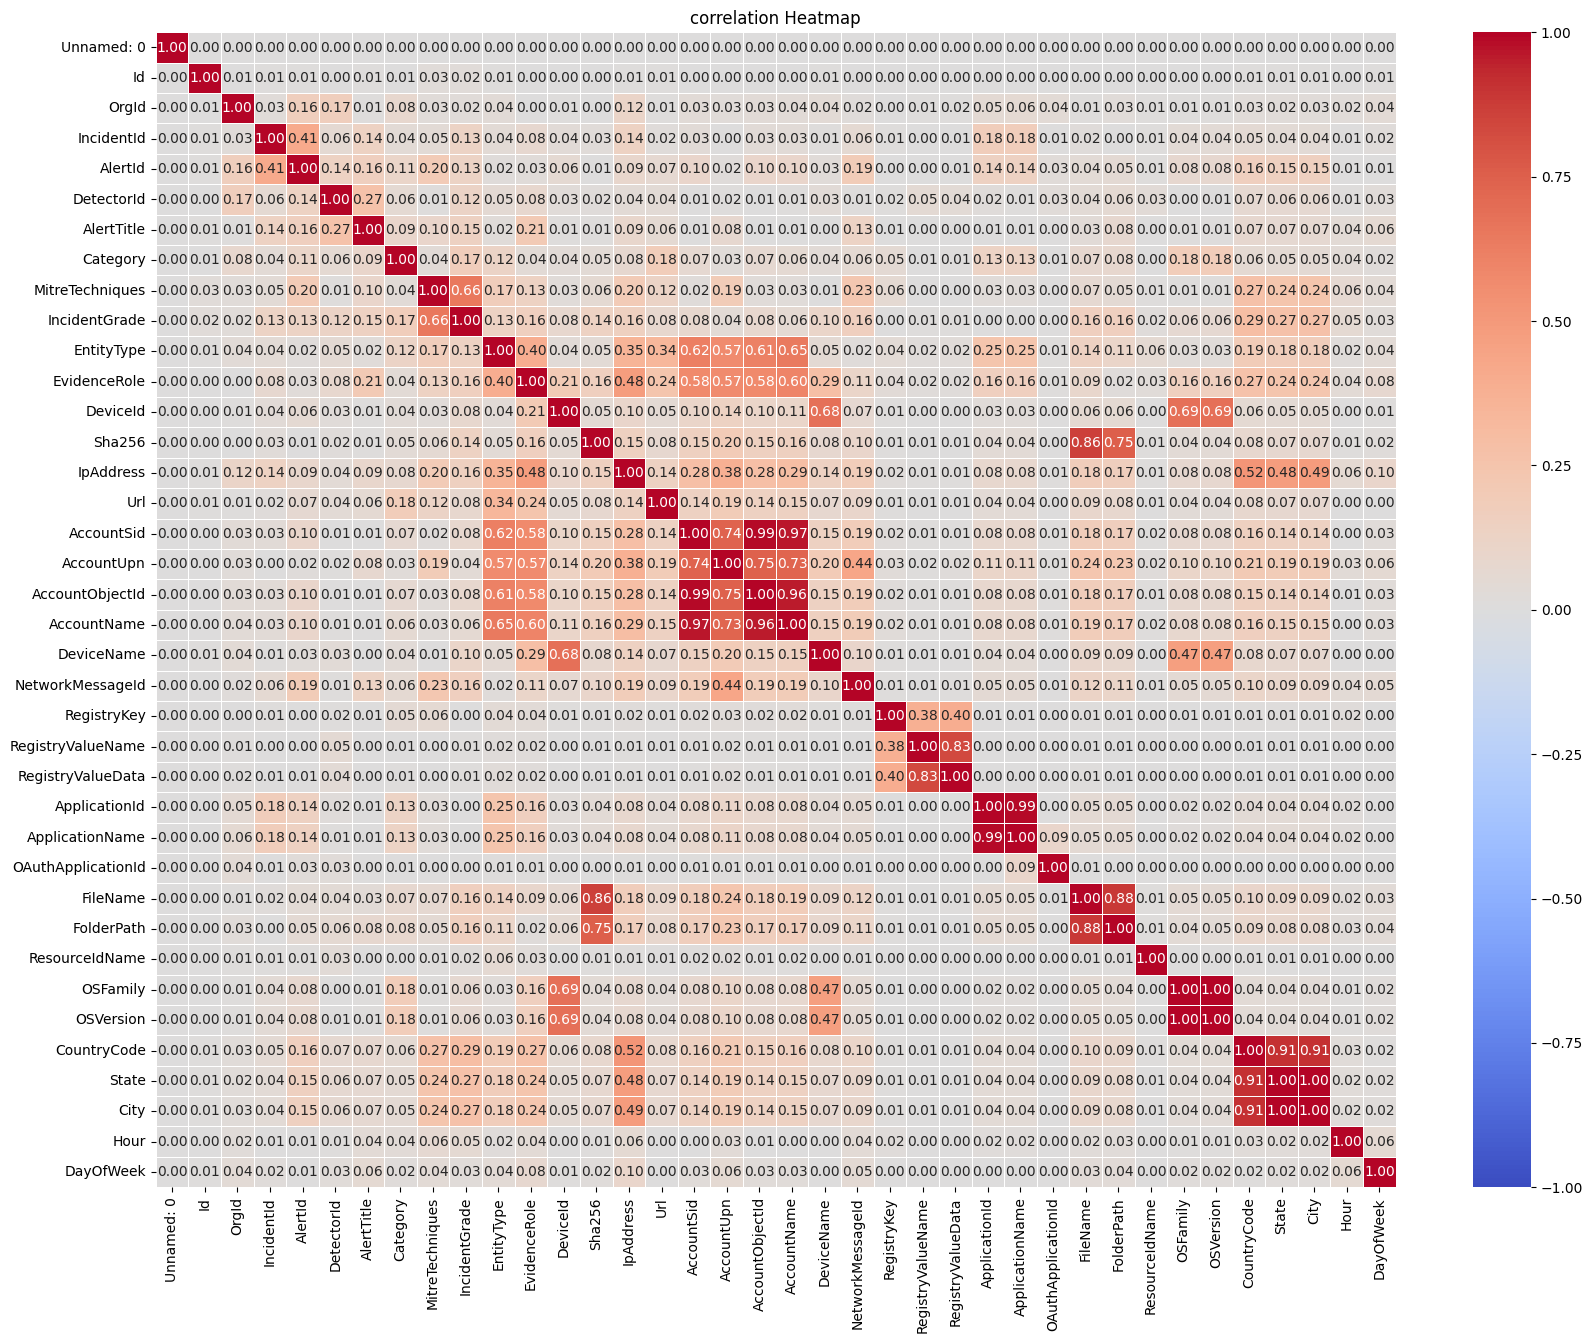

In [42]:
numeric_df=df.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

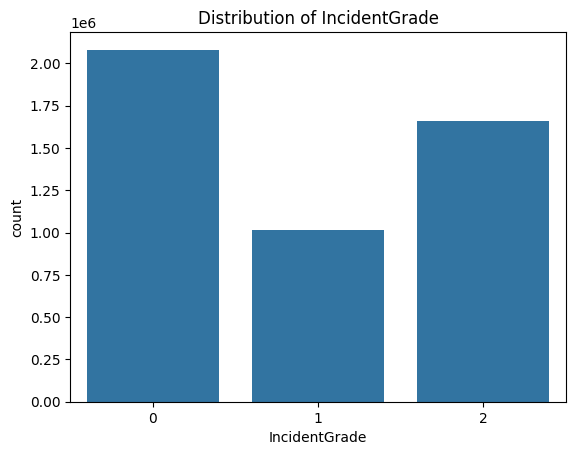

In [46]:
sns.countplot(x=df["IncidentGrade"])
plt.title("Distribution of IncidentGrade")
plt.show()

In [53]:
from sklearn.utils import resample

# Find the minimum class size
min_class_size = df["IncidentGrade"].value_counts().min()

# Downsample each class to the minimum class size
df_balanced = pd.concat([
    resample(df[df["IncidentGrade"] == cls], 
             replace=False, 
             n_samples=min_class_size, 
             random_state=42)
    for cls in df["IncidentGrade"].unique()
])

# Verify new class distribution
print(df_balanced["IncidentGrade"].value_counts())


IncidentGrade
0    1015782
2    1015782
1    1015782
Name: count, dtype: int64


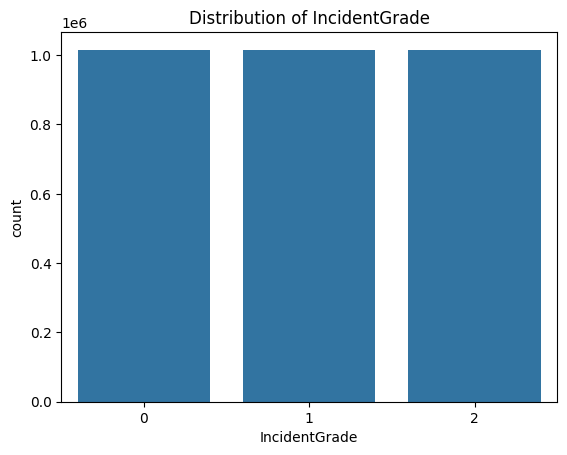

In [47]:
sns.countplot(x=df_balanced["IncidentGrade"])
plt.title("Distribution of IncidentGrade")
plt.show()

In [54]:
df_balanced.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Hour,DayOfWeek
759107,987842480360,624,3063,18385,1,1,10,284,0,18,...,289573,117668,3586,5,66,242,1445,10630,18,6
245538,146028891733,3,191509,259296,36,228,12,64,0,29,...,289573,117668,3586,5,66,242,1445,10630,18,1
169625,1348619734630,136,135867,926958,0,0,10,104,0,7,...,289573,117668,3586,5,66,242,1445,10630,1,2
1318681,1056561956270,149,7874,256085,2,2,1,284,0,29,...,289573,117668,3586,5,66,242,1445,10630,10,3
805776,1649267446501,38,550327,1653342,465,1176,10,282,0,30,...,289573,117668,3586,5,66,242,1445,10630,4,3


In [64]:
numeric_columns = df.select_dtypes(include=['number']).columns

In [65]:
scaler = StandardScaler()
data_scaled =scaler.fit_transform(df[numeric_columns])

In [68]:
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)

In [69]:
data_scaled_df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Hour,DayOfWeek
0,1.746956,-0.402060,-0.430993,0.612576,-0.183096,-0.186111,0.817750,1.044017,-1.033501,-1.149637,...,-3.164932,-3.210306,0.028145,0.144152,0.144256,0.29167,0.266328,0.266047,-1.054941,0.271369
1,0.171677,-0.383965,-0.542857,-0.876316,-0.166989,-0.254894,0.031944,1.044017,-1.033501,-0.180283,...,0.335187,0.312063,0.028145,0.144152,0.144256,0.29167,0.266328,0.266047,-0.317623,-1.337608
2,0.500581,0.050304,0.663016,0.874266,0.709700,-0.218321,-0.753861,-1.380946,-1.033501,-0.180283,...,0.335187,0.312063,0.028145,0.144152,0.144256,0.29167,0.266328,0.266047,-1.349868,0.271369
3,1.193011,0.058059,0.311322,-0.822760,-0.153183,-0.149450,1.865490,-0.949103,1.232803,-1.149637,...,-2.026085,-3.056607,0.028145,0.144152,0.144256,0.29167,0.266328,0.266047,0.567159,1.344020
4,0.327473,-0.329681,3.786186,2.291627,-0.019724,4.878027,-0.491926,1.044017,-1.033501,-1.149637,...,-2.725383,0.212113,0.028145,0.144152,0.144256,0.29167,0.266328,0.266047,-1.497332,1.880346


In [70]:
df_balanced.to_csv('train_balance_dataset.csv', index=False)

In [71]:
X = df_balanced.drop(columns=['IncidentGrade'])
y = df_balanced['IncidentGrade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [72]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training Logistic Regression...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.39      0.59      0.47    253945
     Class 1       0.38      0.17      0.23    253946
     Class 2       0.46      0.49      0.47    253946

    accuracy                           0.41    761837
   macro avg       0.41      0.41      0.39    761837
weighted avg       0.41      0.41      0.39    761837


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99    253945
     Class 1       0.99      0.99      0.99    253946
     Class 2       0.99      0.99      0.99    253946

    accuracy                           0.99    761837
   macro avg       0.99      0.99      0.99    761837
weighted avg       0.99      0.99      0.99    761837



In [73]:
#Feature selection random forest
rf = RandomForestClassifier(n_estimators=200, random_state=100, n_jobs=-1,criterion="entropy",max_depth=10)

In [74]:
rf.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [75]:
fs_score=pd.DataFrame({
    "columns":X.columns,
    "score": rf.feature_importances_
}).sort_values("score",ascending=False)

In [76]:
fs_score

,columns,score
7,MitreTechniques,3.324110e-01
1,OrgId,1.482210e-01
2,IncidentId,1.079490e-01
4,DetectorId,1.003210e-01
5,AlertTitle,7.483822e-02
3,AlertId,6.223073e-02
6,Category,5.688046e-02
8,EntityType,1.865018e-02
31,CountryCode,1.240594e-02
12,IpAddress,1.075333e-02


In [83]:
list(fs_score.head(20)["columns"].values)

['MitreTechniques',
 'OrgId',
 'IncidentId',
 'DetectorId',
 'AlertTitle',
 'AlertId',
 'Category',
 'EntityType',
 'CountryCode',
 'IpAddress',
 'AccountUpn',
 'DeviceName',
 'AccountObjectId',
 'AccountSid',
 'State',
 'City',
 'EvidenceRole',
 'NetworkMessageId',
 'AccountName',
 'DayOfWeek']

In [84]:
selected_features =list(fs_score.sort_values("score",ascending=False).head(20)["columns"].values)

In [102]:
X_new=X[selected_features]

In [103]:
X_new.head()

,MitreTechniques,OrgId,IncidentId,DetectorId,AlertTitle,AlertId,Category,EntityType,CountryCode,IpAddress,AccountUpn,DeviceName,AccountObjectId,AccountSid,State,City,EvidenceRole,NetworkMessageId,AccountName,DayOfWeek
759107,284,624,3063,1,1,18385,10,18,242,360606,673934,153085,425863,441377,1445,10630,1,529644,453297,6
245538,64,3,191509,36,228,259296,12,29,242,360606,673934,153085,425863,441377,1445,10630,1,529644,453297,1
169625,104,136,135867,0,0,926958,10,7,242,360606,673934,153085,425863,441377,1445,10630,1,529644,453297,2
1318681,284,149,7874,2,2,256085,1,29,242,360606,673934,153085,425863,441377,1445,10630,1,529644,453297,3
805776,282,38,550327,465,1176,1653342,10,30,242,360606,673934,153085,425863,441377,1445,10630,0,529644,111836,3


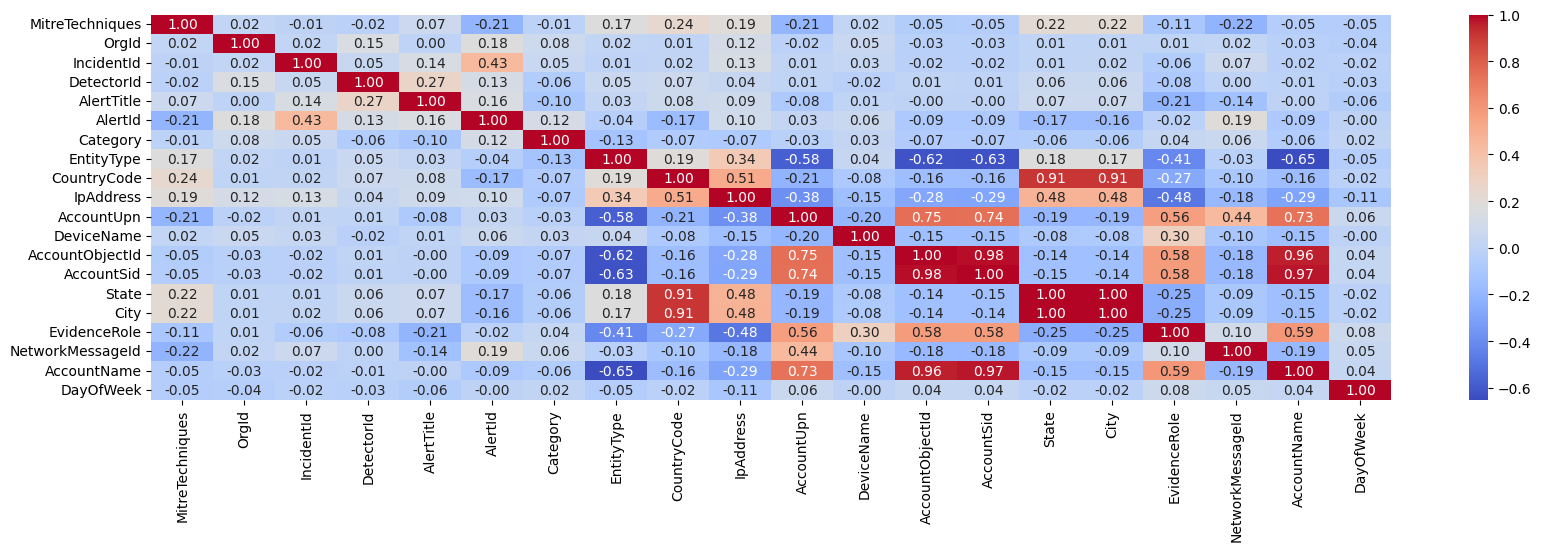

In [104]:
data_x = X_new.corr()
plt.figure(figsize=(20,5))
sns.heatmap(data=data_x,annot=True,fmt=".2f",cmap="coolwarm")
plt.show()

In [105]:
X_new.drop(["City","AccountSid","AccountObjectId","State"],axis=1,inplace=True)

C:\Users\deepa\AppData\Local\Temp\ipykernel_21664\3025265318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new.drop(["City","AccountSid","AccountObjectId","State"],axis=1,inplace=True)


In [106]:
X_new.shape

(3047346, 16)

In [107]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.25,random_state=50)

In [109]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=8,random_state=42,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training Logistic Regression...


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.47      0.47      0.47    253784
     Class 1       0.50      0.31      0.38    253365
     Class 2       0.49      0.68      0.57    254688

    accuracy                           0.48    761837
   macro avg       0.49      0.48      0.47    761837
weighted avg       0.49      0.48      0.47    761837


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.91      0.86    253784
     Class 1       0.79      0.76      0.78    253365
     Class 2       0.83      0.75      0.79    254688

    accuracy                           0.81    761837
   macro avg       0.81      0.81      0.81    761837
weighted avg       0.81      0.81      0.81    761837



In [ ]:
advanced_models = {
    'Random Forest': RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=50),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)}

# Training and evaluation for advanced models
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

In [113]:
print(X_new.shape, y.shape)

(3047346, 16) (3047346,)


In [114]:
from sklearn.model_selection import train_test_split

#10%
X_sample, _, y_sample, _ = train_test_split(X_new, y, test_size=0.90, random_state=50)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.25, random_state=50)

print(X_train.shape, X_test.shape)


(228550, 16) (76184, 16)


In [115]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int8')  #since its a categorical feature
y_test = y_test.astype('int8')

In [116]:
print(X_train.shape, X_test.shape)

(228550, 16) (76184, 16)


In [125]:
advanced_models = {
    'Random Forest': RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=50),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)}

# Training and evaluation for advanced models
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(f"Cross-validation accuracy {name}: ", score.mean())


Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.95      0.89     25331
     Class 1       0.84      0.90      0.87     25533
     Class 2       0.97      0.78      0.86     25320

    accuracy                           0.88     76184
   macro avg       0.88      0.88      0.87     76184
weighted avg       0.88      0.88      0.87     76184

Cross-validation accuracy {name}:  0.8744344788592829

Training Gradient Boosting...
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.92      0.89     25331
     Class 1       0.83      0.87      0.85     25533
     Class 2       0.91      0.80      0.85     25320

    accuracy                           0.86     76184
   macro avg       0.87      0.86      0.86     76184
weighted avg       0.87      0.86      0.86     76184

Cross-validation accuracy {name}:  nan


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\deepa\AppData\L

In [121]:
xgbmodel = xgb.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)
print(f"\nTraining XGB...")
xgbmodel.fit(X_train, y_train)
y_pred = xgbmodel.predict(X_test)
print(f"XGB Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training XGB...
XGB Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96     25331
     Class 1       0.93      0.96      0.95     25533
     Class 2       0.96      0.93      0.94     25320

    accuracy                           0.95     76184
   macro avg       0.95      0.95      0.95     76184
weighted avg       0.95      0.95      0.95     76184



In [124]:
score = cross_val_score(xgbmodel, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validation accuracy: ", score.mean())

Cross-validation accuracy:  0.9462218339840011


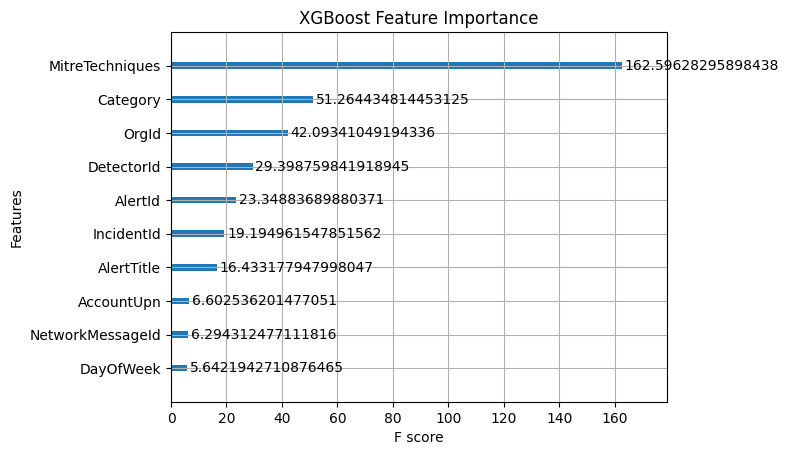

In [127]:
xgb.plot_importance(xgbmodel, importance_type="gain", max_num_features=10)  # Show top 10 features
plt.title("XGBoost Feature Importance")
plt.show()

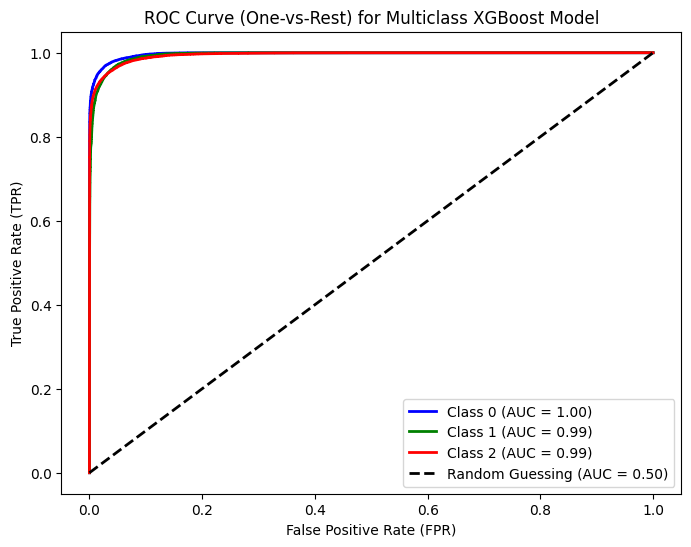

Class 0 AUC: 0.9971
Class 1 AUC: 0.9946
Class 2 AUC: 0.9946


In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_test))

y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_proba = xgbmodel.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing (AUC = 0.50)")

# Labels, title, and legend
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (One-vs-Rest) for Multiclass XGBoost Model')
plt.legend(loc='lower right')
plt.show()

for i in range(n_classes):
    print(f"Class {i} AUC: {roc_auc[i]:.4f}")


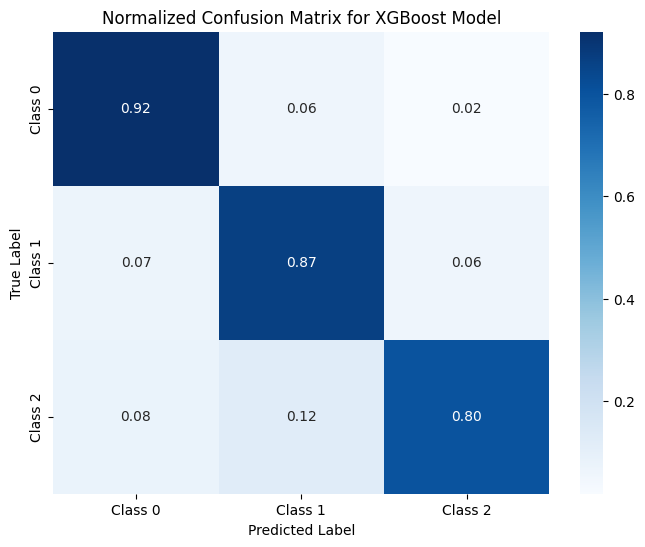

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize Confusion Matrix (Optional: Change `normalize=False` if not needed)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels dynamically
class_labels = [f"Class {i}" for i in range(len(np.unique(y_test)))]

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix for XGBoost Model")
plt.show()


In [132]:
import joblib
best_model = "XGB.joblib"
with open(best_model, 'wb') as file:
    joblib.dump(xgbmodel, file)

In [145]:
import gc

# del df

# del X_train
# del X_test
# del y_train
# del y_test
del xgbmodel

# Garbage collect to release memory
gc.collect()

1151